In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import string
import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler

In [2]:
import os
from langdetect import detect
from googletrans import Translator
import emoji

In [3]:
reviews_df = pd.read_excel('Project Corpora/train_reviews.xlsx')

In [4]:
reviews_df.tail()

,index,comments
721397,12494,"We had a good time, the apartment has a great ..."
721398,12494,Great apartment in very central location. The ...
721399,12494,"We are Airbnb Super Hosts too, so trust me, Li..."
721400,12494,We had a lovely stay at this apartment. Sofia ...
721401,12494,"Clean, very good position, easy checkin, the p..."


In [5]:
reviews_df.isna().sum()

index       0
comments    4
dtype: int64

In [6]:
reviews_df[reviews_df.isnull().any(axis=1)]

,index,comments
97996,1654,NaN
334443,5789,NaN
370383,6413,NaN
403395,6957,NaN


In [7]:
# reviews_df = reviews_df.dropna()

In [8]:
reviews_df.shape

(721402, 2)

In [9]:
#type_counts = reviews_df.groupby('comments').size()
#type_counts

In [10]:
# Checking if there are rows where 'comments' is numberic
numeric_column = pd.to_numeric(reviews_df['comments'], errors='coerce')
numeric_rows = reviews_df[~numeric_column.isna()] # rows with successful conversion
numeric_rows

,index,comments
26593,468,10
62305,1062,1
83596,1397,1
160070,2696,0
211858,3593,9
229643,3930,9
244104,4186,8.0
250023,4304,10
255300,4379,10
261031,4472,0


In [34]:
# reviews_df['comments'] = reviews_df['comments'].astype('string')

## Pre-process Reviews Data

### Detecting Languages (TIME-CONSUMING SECTION)

In [11]:
# Define a function to detect the language of a string
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = None
    return lang

In [12]:
reviews_df = pd.read_excel('Project Corpora/train_reviews.xlsx')
reviews_df.to_csv('output/train_reviews.csv', index=False)

In [13]:
# Detecting languages 
source_file = 'output/train_reviews.csv'
destination_file = 'output/reviews_with_language.csv'

chunk_size = 1000
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    chunk['comments'] = chunk['comments'].str.replace('<br/>', '')
    chunk['language'] = chunk['comments'].apply(detect_language)
    chunk.to_csv(destination_file, 
                 index=False, 
                 mode='a', 
                 header=not os.path.exists(destination_file))

722it [54:18,  4.51s/it] 


In [27]:
reviews_df = pd.read_csv('output/reviews_with_language.csv')
reviews_df.iloc[1000:1110, :]

,index,comments,language
1000,23,"A well equipt, clean unit in an ideal location...",en
1001,23,Great place!,en
1002,23,Joao and his colleagues are all very kind and ...,en
1003,23,L'appartement est très bien. L'agence est top ...,fr
1004,23,1ère visite de Lisbonne: le logement est situé...,fr
...,...,...,...
1105,24,"Newly, well located, fully equipped and clean ...",en
1106,24,"Very nice place! Great location, very helpful ...",en
1107,24,The appartement was pretty and of good taste o...,en
1108,24,Wonderful little apartment in a beautiful city!,en


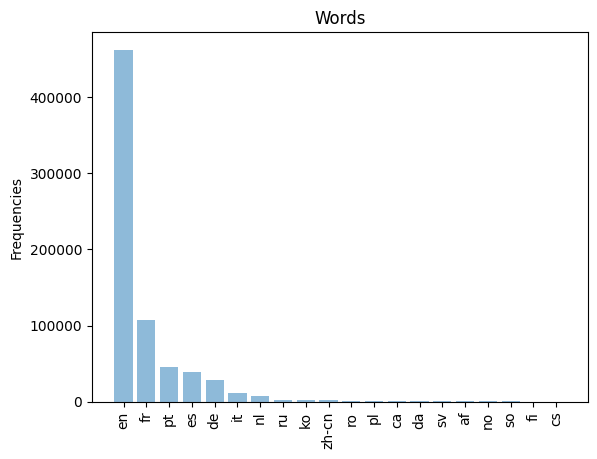

In [29]:
freq = pd.Series(reviews_df['language']).value_counts()

x_labels = freq.index[0:20]
values = freq[:20]
plt.bar(x_labels, values, align='center', alpha=0.5)
#plt.xticks(values, x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

### Replacing Emoji

In [16]:
reviews_df = pd.read_csv('output/reviews_with_language.csv')
reviews_df.head(10)

,index,comments,language
0,1,this is a very cozy and comfortable house to s...,en
1,1,good,so
2,1,"My first hostel experience, and all I have to ...",en
3,1,Das Hostel war neu und deshalb funktionierte a...,de
4,1,"It was fine for a dorm, but I think for the pe...",en
5,1,Our stay in Lisbon Tip Hostel was very good. T...,en
6,1,Close to shops in town and a comfortable place...,en
7,1,Young and friendly staff. Great location along...,en
8,1,The place is just off the Parque metro stop wh...,en
9,1,Had a nice stay at this hostel. The beds were ...,en


In [17]:
source_file = 'output/reviews_with_language.csv'
detination_file = 'output/train_reviews_with_emoji.csv'

# Create an iterator over the chunks
chunk_size = 1000
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    chunk['comments'] = chunk['comments'].astype('string')
    chunk['comments_no_emoji'] = chunk['comments'].apply(lambda x: emoji.demojize(x) if pd.notna(x) else '')
    chunk.to_csv(detination_file,   
                 index=False, 
                 mode='a', 
                 header=not os.path.exists(detination_file))

722it [00:27, 26.12it/s]


In [18]:
reviews_df = pd.read_csv(detination_file)
reviews_df.head(5)

,index,comments,language,comments_no_emoji
0,1,this is a very cozy and comfortable house to s...,en,this is a very cozy and comfortable house to s...
1,1,good,so,good
2,1,"My first hostel experience, and all I have to ...",en,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...,de,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe...",en,"It was fine for a dorm, but I think for the pe..."


## Grouping by Index - to do counts and merge

In [19]:
reviews_df['comments'] = reviews_df['comments'].astype('string')
reviews_df = reviews_df.dropna()

In [20]:
grouped = reviews_df.groupby(['index', 'language']).agg({'comments': 'count'})
grouped = grouped.reset_index()


final_grouped = grouped.groupby('index').agg({'language': 'nunique', 'comments': 'sum'})
final_grouped = final_grouped.reset_index()

# rename the columns to the desired names
final_grouped.columns = ['index', 'unique_languages_count', 'total_comments_count']
final_grouped

,index,unique_languages_count,total_comments_count
0,1,7,50
1,5,6,41
2,8,8,168
3,9,6,32
4,10,3,13
...,...,...,...
8461,12490,7,32
8462,12491,4,10
8463,12492,9,312
8464,12493,5,35


In [21]:
reviews_df_eng = reviews_df[reviews_df['language'] == 'en']

grouped_eng = reviews_df_eng.groupby(['index']).agg({'comments': ['count', ' '.join]})
grouped_eng.columns = ['_'.join(col).strip() for col in grouped_eng.columns.values]
grouped_eng = grouped_eng.reset_index()

# Rename the columns of the DataFrame
grouped_eng.columns = ['index', 'eng_comment_count', 'eng_reviews_merged']
grouped_eng

,index,eng_comment_count,eng_reviews_merged
0,1,30,this is a very cozy and comfortable house to s...
1,5,17,We really enjoyed staying at Sonias place. The...
2,8,145,Shani was very helpful throughout our process!...
3,9,16,Great little space; lovely hosts - clean and w...
4,10,11,"WOW, what a great stay! The spacious apartment..."
...,...,...,...
8293,12490,14,Excellent very well equiped apartment! Thank y...
8294,12491,7,I am so happy to found this accomodation near ...
8295,12492,212,We were very happy to find this place. The com...
8296,12493,27,"Nice place, nice location, easy communication!..."


In [22]:
merged_df = pd.merge(final_grouped, grouped_eng, on='index', how='left')
merged_df

,index,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged
0,1,7,50,30.0,this is a very cozy and comfortable house to s...
1,5,6,41,17.0,We really enjoyed staying at Sonias place. The...
2,8,8,168,145.0,Shani was very helpful throughout our process!...
3,9,6,32,16.0,Great little space; lovely hosts - clean and w...
4,10,3,13,11.0,"WOW, what a great stay! The spacious apartment..."
...,...,...,...,...,...
8461,12490,7,32,14.0,Excellent very well equiped apartment! Thank y...
8462,12491,4,10,7.0,I am so happy to found this accomodation near ...
8463,12492,9,312,212.0,We were very happy to find this place. The com...
8464,12493,5,35,27.0,"Nice place, nice location, easy communication!..."
